<a href="https://colab.research.google.com/github/daanishrasheed/Unit2_Build_Project/blob/master/notebooks/BuildWeekUnit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
#from google.colab import files
#uploaded = files.upload()

Saving plays.csv to plays.csv


In [1]:
import pandas as pd
df = pd.read_csv('plays.csv', engine='python')
print(df.shape)
df.head()

(14193, 27)


,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,SpecialTeamsPlayType,KickReturnYardage,PassLength,PassResult,YardsAfterCatch,PlayResult,playDescription
0,2017091004,37,1,15:00:00,0,0,DET,DET,35.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,False,True,Kickoff,23.0,NaN,NaN,NaN,42,K.Redfern kicks 65 yards from DET 35 to ARZ 0....
1,2017091004,73,1,14:54:00,1,10,ARI,ARI,23.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,NaN,NaN,-2.0,C,6.0,4,(14:54) (Shotgun) C.Palmer pass short right to...
2,2017091004,97,1,14:16:00,2,6,ARI,ARI,27.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,NaN,NaN,NaN,NaN,NaN,2,(14:16) Da.Johnson up the middle to ARZ 29 for...
3,2017091004,118,1,13:34:00,3,4,ARI,ARI,29.0,SHOTGUN,"1 RB, 0 TE, 4 WR",5.0,4.0,"4 DL, 1 LB, 6 DB",0,0,0,0,False,False,NaN,NaN,7.0,C,7.0,15,(13:34) (Shotgun) C.Palmer pass short middle t...
4,2017091004,153,1,12:51:00,1,10,ARI,ARI,44.0,SHOTGUN,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,NaN,NaN,NaN,NaN,-2,(12:51) (Shotgun) Da.Johnson left end to ARZ 4...


In [2]:
print(len(df))

14193


In [3]:
df = df[~df['isSTPlay']]
print(len(df))

11558


In [4]:
df = df[~df['playDescription'].str.contains("kneels")]
print (len(df))

11428


In [5]:
df.tail(5)

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,SpecialTeamsPlayType,KickReturnYardage,PassLength,PassResult,YardsAfterCatch,PlayResult,playDescription
14187,2017101501,4675,5,05:09:00,2,11,CHI,BAL,41.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,7.0,"3 DL, 4 LB, 4 DB",24,24,24,24,False,False,NaN,NaN,1.0,I,NaN,0,(5:09) M.Trubisky pass incomplete short left t...
14188,2017101501,4697,5,04:26:00,3,11,CHI,BAL,41.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,6.0,"1 DL, 4 LB, 6 DB",24,24,24,24,False,False,NaN,NaN,18.0,C,0.0,18,(4:26) (Shotgun) M.Trubisky pass deep middle t...
14189,2017101501,4721,5,03:43:00,1,10,CHI,BAL,23.0,I_FORM,"2 RB, 2 TE, 1 WR",8.0,NaN,"3 DL, 4 LB, 4 DB",24,24,24,24,False,False,NaN,NaN,NaN,NaN,NaN,-2,(3:43) Jo.Howard right guard to BLT 25 for -2 ...
14190,2017101501,4742,5,03:00:00,2,12,CHI,BAL,25.0,I_FORM,"2 RB, 2 TE, 1 WR",9.0,NaN,"3 DL, 4 LB, 4 DB",24,24,24,24,False,False,NaN,NaN,NaN,NaN,NaN,1,(3:00) Jo.Howard left guard to BLT 24 for 1 ya...
14191,2017101501,4763,5,02:16:00,3,11,CHI,BAL,24.0,I_FORM,"2 RB, 2 TE, 1 WR",9.0,NaN,"3 DL, 4 LB, 4 DB",24,24,24,24,False,False,NaN,NaN,NaN,NaN,NaN,2,(2:16) Jo.Howard left tackle to BLT 22 for 2 y...


In [6]:
df = df.drop(df[df.quarter==5].index)

In [7]:
df.tail()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,SpecialTeamsPlayType,KickReturnYardage,PassLength,PassResult,YardsAfterCatch,PlayResult,playDescription
14168,2017101501,4129,4,01:37:00,0,0,BAL,CHI,2.0,I_FORM,"1 RB, 2 TE, 2 WR",7.0,NaN,"2 DL, 4 LB, 5 DB",22,24,24,24,False,False,NaN,NaN,NaN,NaN,NaN,0,TWO-POINT CONVERSION ATTEMPT. J.Flacco pass to...
14170,2017101501,4204,4,01:31:00,1,20,CHI,CHI,15.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,6.0,"1 DL, 5 LB, 5 DB",24,24,24,24,False,False,NaN,NaN,4.0,C,0.0,4,(1:31) (Shotgun) M.Trubisky FUMBLES (Aborted) ...
14171,2017101501,4228,4,01:09:00,2,16,CHI,CHI,19.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,4.0,"1 DL, 5 LB, 5 DB",24,24,24,24,False,False,NaN,NaN,NaN,S,NaN,-4,"(1:09) (No Huddle, Shotgun) M.Trubisky sacked ..."
14172,2017101501,4247,4,00:31:00,3,20,CHI,CHI,15.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,NaN,"1 DL, 5 LB, 5 DB",24,24,24,24,False,False,NaN,NaN,NaN,NaN,NaN,8,(:31) Jo.Howard right guard pushed ob at CHI 2...
14174,2017101501,4309,4,00:12:00,1,10,BAL,BAL,44.0,EMPTY,"0 RB, 2 TE, 3 WR",2.0,3.0,"1 DL, 4 LB, 6 DB",24,24,24,24,False,False,NaN,NaN,4.0,C,12.0,16,(:12) (Shotgun) J.Flacco pass short right to M...


In [8]:
def translate_game_clock(row):
    raw_game_clock = row['GameClock']
    quarter = row['quarter']
    minutes, seconds_raw = raw_game_clock.partition(':')[::2]

    seconds = seconds_raw.partition(':')[0]

    total_seconds_left_in_quarter = int(seconds) + (int(minutes) * 60)

    if quarter == 3 or quarter == 1:
        return total_seconds_left_in_quarter + 900
    elif quarter == 4 or quarter == 2:
        return total_seconds_left_in_quarter

if 'GameClock' in list (df.columns):
    df['secondsLeftInHalf'] = df.apply(translate_game_clock, axis=1)

if 'quarter' in list(df.columns):
    df['half'] = df['quarter'].map(lambda q: 2 if q > 2 else 1)

In [9]:
def yards_to_endzone(row):
    if row['possessionTeam'] == row['yardlineSide']:
        return 100 - row['yardlineNumber']
    else :
        return row['yardlineNumber']

df['yardsToEndzone'] = df.apply(yards_to_endzone, axis = 1)

In [10]:
df.head()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,SpecialTeamsPlayType,KickReturnYardage,PassLength,PassResult,YardsAfterCatch,PlayResult,playDescription,secondsLeftInHalf,half,yardsToEndzone
1,2017091004,73,1,14:54:00,1,10,ARI,ARI,23.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,NaN,NaN,-2.0,C,6.0,4,(14:54) (Shotgun) C.Palmer pass short right to...,1794,1,77.0
2,2017091004,97,1,14:16:00,2,6,ARI,ARI,27.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,NaN,NaN,NaN,NaN,NaN,2,(14:16) Da.Johnson up the middle to ARZ 29 for...,1756,1,73.0
3,2017091004,118,1,13:34:00,3,4,ARI,ARI,29.0,SHOTGUN,"1 RB, 0 TE, 4 WR",5.0,4.0,"4 DL, 1 LB, 6 DB",0,0,0,0,False,False,NaN,NaN,7.0,C,7.0,15,(13:34) (Shotgun) C.Palmer pass short middle t...,1714,1,71.0
4,2017091004,153,1,12:51:00,1,10,ARI,ARI,44.0,SHOTGUN,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,NaN,NaN,NaN,NaN,-2,(12:51) (Shotgun) Da.Johnson left end to ARZ 4...,1671,1,56.0
5,2017091004,174,1,12:13:00,2,12,ARI,ARI,42.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,4.0,"4 DL, 3 LB, 4 DB",0,0,0,0,True,False,NaN,NaN,7.0,I,NaN,0,(12:13) C.Palmer pass incomplete short right t...,1633,1,58.0


In [11]:
df['personnel.offense'].value_counts()

1 RB, 1 TE, 3 WR                   6622
1 RB, 2 TE, 2 WR                   2208
2 RB, 1 TE, 2 WR                    888
1 RB, 3 TE, 1 WR                    507
2 RB, 2 TE, 1 WR                    245
1 RB, 0 TE, 4 WR                    128
2 RB, 0 TE, 3 WR                    119
0 RB, 1 TE, 4 WR                    107
6 OL, 1 RB, 2 TE, 1 WR              101
6 OL, 1 RB, 1 TE, 2 WR               95
6 OL, 2 RB, 1 TE, 1 WR               42
1 RB, 2 TE, 1 WR,1 DL                41
6 OL, 2 RB, 2 TE, 0 WR               34
2 RB, 3 TE, 0 WR                     24
0 RB, 2 TE, 3 WR                     24
1 RB, 1 TE, 2 WR,1 DL                24
6 OL, 2 RB, 0 TE, 2 WR               19
6 OL, 1 RB, 3 TE, 0 WR               19
6 OL, 1 RB, 0 TE, 3 WR               17
7 OL, 1 RB, 0 TE, 2 WR               14
3 RB, 1 TE, 1 WR                     12
6 OL, 1 RB, 2 TE, 0 WR,1 DL           6
1 RB, 3 TE, 0 WR,1 DL                 6
6 OL, 1 RB, 1 TE, 1 WR,1 DL           4
0 RB, 0 TE, 5 WR                      4


In [12]:
df['personnel.defense'].value_counts()

4 DL, 2 LB, 5 DB          3149
4 DL, 3 LB, 4 DB          1972
3 DL, 4 LB, 4 DB          1703
2 DL, 4 LB, 5 DB          1600
3 DL, 3 LB, 5 DB          1083
2 DL, 3 LB, 6 DB           711
1 DL, 4 LB, 6 DB           261
4 DL, 1 LB, 6 DB           231
3 DL, 2 LB, 6 DB           226
4 DL, 4 LB, 3 DB            66
1 DL, 5 LB, 5 DB            60
2 DL, 2 LB, 7 DB            42
2 DL, 5 LB, 4 DB            41
5 DL, 4 LB, 2 DB            27
3 DL, 1 LB, 7 DB            26
3 DL, 5 LB, 3 DB            23
5 DL, 2 LB, 4 DB            20
5 DL, 3 LB, 3 DB            13
6 DL, 3 LB, 2 DB            12
1 DL, 3 LB, 7 DB            11
6 DL, 2 LB, 3 DB            10
0 DL, 4 LB, 7 DB             6
5 DL, 1 LB, 5 DB             6
6 DL, 4 LB, 1 DB             4
2 DL, 4 LB, 4 DB, 1 OL       4
2 DL, 3 LB, 5 DB             3
4 DL, 6 LB, 1 DB             3
3 DL, 4 LB, 3 DB             2
1 DL, 4 LB, 5 DB             2
2 DL, 4 LB, 4 DB             2
4 DL, 2 LB, 4 DB             2
1 DL, 2 LB, 8 DB             2
6 DL, 1 

In [13]:
columns = ['SpecialTeamsPlayType', 'KickReturnYardage', 'PassLength', 'YardsAfterCatch']
df.drop(columns, inplace=True, axis=1)

In [14]:
len(df) - df.count()

gameId                       0
playId                       0
quarter                      0
GameClock                    0
down                         0
yardsToGo                    0
possessionTeam               0
yardlineSide               160
yardlineNumber             160
offenseFormation             8
personnel.offense            1
defendersInTheBox            2
numberOfPassRushers       4678
personnel.defense            1
HomeScoreBeforePlay          0
VisitorScoreBeforePlay       0
HomeScoreAfterPlay           0
VisitorScoreAfterPlay        0
isPenalty                    0
isSTPlay                     0
PassResult                4428
PlayResult                   0
playDescription              0
secondsLeftInHalf            0
half                         0
yardsToEndzone             160
dtype: int64

In [15]:
df = df[df.playId != 2541]

In [16]:
def count_opersonnel(row):
  rb = 0
  te = 0
  wr = 0
  ol = 0
  fb = 0
  pers = row['personnel.offense'].split(', ')
  for p in pers:
    if p[2:4] == 'RB':
      rb = int(p[0])
    if p[2:4] == 'TE':
      te = int(p[0])
    if p[2:4] == 'WR':
      wr = int(p[0])
    if p[2:4] == 'OL':
      ol = int(p[0])
    if p[2:4] == 'DL':
      fb = int(p[0])
  return pd.Series([rb, te, wr, ol, fb])

df[['rb_count', 'te_count', 'wr_count', 'ol_count', 'fb_count']] = df.apply(count_opersonnel, axis=1)

In [17]:
def count_dpersonnel(row):
  dl = 0
  db = 0
  lb = 0
  pers = row['personnel.defense'].split(', ')
  for p in pers:
    if p[2:4] == 'DL':
      dl = int(p[0])
    if p[2:4] == 'DB':
      db = int(p[0])
    if p[2:4] == 'LB':
      lb = int(p[0])
  return pd.Series([dl, db, lb])

df[['dl_count', 'db_count', 'lb_count']] = df.apply(count_dpersonnel, axis=1)

In [18]:
df = df[df.offenseFormation != 'NaN']

In [19]:
y = df[df['offenseFormation'].isnull()]
y

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,PassResult,PlayResult,playDescription,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count
3427,2017091700,2288,3,14:29:00,2,8,BAL,BAL,27.0,NaN,"1 RB, 2 TE, 2 WR",6.0,0.0,"4 DL, 3 LB, 4 DB",21,7,21,7,False,False,C,13,(14:29) J.Flacco pass short middle to M.Willia...,1769,2,73.0,1,2,2,0,0,4,4,3
3434,2017091700,2464,3,11:31:00,2,6,CLE,CLE,22.0,NaN,"1 RB, 1 TE, 3 WR",6.0,0.0,"2 DL, 4 LB, 5 DB",21,7,21,7,False,False,I,0,(11:31) (Shotgun) K.Hogan pass incomplete shor...,1591,2,78.0,1,1,3,0,0,2,5,4
6846,2017092410,2908,3,06:30:00,1,10,TEN,TEN,46.0,NaN,"2 RB, 3 TE, 1 WR",8.0,NaN,"4 DL, 3 LB, 4 DB",16,14,16,14,False,False,NaN,3,(6:30) Direct snap to D.Murray. D.Henry right...,1290,2,54.0,2,3,1,0,0,4,4,3
11380,2017100804,1367,2,08:24:00,1,10,MIA,MIA,35.0,NaN,"1 RB, 2 TE, 3 WR",6.0,0.0,"2 DL, 4 LB, 5 DB",10,3,10,3,False,False,I,0,(8:24) Direct snap to M.Gray. M.Gray pass inc...,504,1,65.0,1,2,3,0,0,2,5,4
11561,2017100808,2144,2,00:03:00,3,3,SEA,LA,29.0,NaN,"1 RB, 1 TE, 3 WR",6.0,0.0,"2 DL, 4 LB, 5 DB",10,7,10,7,False,False,I,0,(:03) (No Huddle) R.Wilson spiked the ball to ...,3,1,29.0,1,1,3,0,0,2,5,4
11634,2017100808,4169,4,00:35:00,1,10,LA,SEA,20.0,NaN,"1 RB, 1 TE, 3 WR",4.0,0.0,"4 DL, 2 LB, 5 DB",10,16,10,16,False,False,I,0,(:35) (No Huddle) J.Goff spiked the ball to st...,35,2,20.0,1,1,3,0,0,4,5,2
13877,2017101600,626,1,04:24:00,1,10,TEN,IND,40.0,NaN,"2 RB, 1 TE, 3 WR",6.0,NaN,"3 DL, 4 LB, 4 DB",3,3,3,3,False,False,NaN,0,(4:24) Direct snap to D.Murray. D.Murray righ...,1164,1,40.0,2,1,3,0,0,3,4,4


In [22]:
df = df[df.playId != 2288]
df = df[df.playId != 2464]
df = df[df.playId != 2908]
df = df[df.playId != 1367]
df = df[df.playId != 2144]
df = df[df.playId != 4169]
df = df[df.playId != 626]
df = df[df.playId != 5846]

In [23]:
len(df) - df.count()

gameId                       0
playId                       0
quarter                      0
GameClock                    0
down                         0
yardsToGo                    0
possessionTeam               0
yardlineSide               160
yardlineNumber             160
offenseFormation             0
personnel.offense            0
defendersInTheBox            1
numberOfPassRushers       4665
personnel.defense            0
HomeScoreBeforePlay          0
VisitorScoreBeforePlay       0
HomeScoreAfterPlay           0
VisitorScoreAfterPlay        0
isPenalty                    0
isSTPlay                     0
PassResult                4416
PlayResult                   0
playDescription              0
secondsLeftInHalf            0
half                         0
yardsToEndzone             160
rb_count                     0
te_count                     0
wr_count                     0
ol_count                     0
fb_count                     0
dl_count                     0
db_count

In [24]:
df['PlayType'] = 'no'
df1 = df[df['PassResult'].isnull()]
df2 = df[df['PassResult'].notnull()]

In [25]:
df1.head()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,PassResult,PlayResult,playDescription,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,PlayType
2,2017091004,97,1,14:16:00,2,6,ARI,ARI,27.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,NaN,2,(14:16) Da.Johnson up the middle to ARZ 29 for...,1756,1,73.0,1,1,3,0,0,4,5,2,no
4,2017091004,153,1,12:51:00,1,10,ARI,ARI,44.0,SHOTGUN,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,-2,(12:51) (Shotgun) Da.Johnson left end to ARZ 4...,1671,1,56.0,1,2,2,0,0,4,4,3,no
7,2017091004,233,1,12:00:00,1,10,DET,ARI,26.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,NaN,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,NaN,5,(12:00) A.Abdullah left end ran ob at ARZ 21 f...,1620,1,26.0,1,2,2,0,0,3,4,4,no
11,2017091004,316,1,11:08:00,1,10,DET,DET,15.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,NaN,"2 DL, 4 LB, 5 DB",0,7,0,7,False,False,NaN,0,(11:08) A.Abdullah right end to DET 15 for no ...,1568,1,85.0,1,1,3,0,0,2,5,4,no
16,2017091004,432,1,08:57:00,2,7,ARI,ARI,36.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,7,0,7,False,False,NaN,6,(8:57) Da.Johnson left tackle to ARZ 42 for 6 ...,1437,1,64.0,1,2,2,0,0,4,4,3,no


In [26]:
df2.head()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,PassResult,PlayResult,playDescription,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,PlayType
1,2017091004,73,1,14:54:00,1,10,ARI,ARI,23.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,C,4,(14:54) (Shotgun) C.Palmer pass short right to...,1794,1,77.0,1,1,3,0,0,4,5,2,no
3,2017091004,118,1,13:34:00,3,4,ARI,ARI,29.0,SHOTGUN,"1 RB, 0 TE, 4 WR",5.0,4.0,"4 DL, 1 LB, 6 DB",0,0,0,0,False,False,C,15,(13:34) (Shotgun) C.Palmer pass short middle t...,1714,1,71.0,1,0,4,0,0,4,6,1,no
5,2017091004,174,1,12:13:00,2,12,ARI,ARI,42.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,4.0,"4 DL, 3 LB, 4 DB",0,0,0,0,True,False,I,0,(12:13) C.Palmer pass incomplete short right t...,1633,1,58.0,1,2,2,0,0,4,4,3,no
6,2017091004,207,1,12:08:00,3,12,ARI,ARI,42.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,4.0,"4 DL, 1 LB, 6 DB",0,0,0,0,False,False,IN,0,(12:08) (Shotgun) C.Palmer pass short left int...,1628,1,58.0,1,1,3,0,0,4,6,1,no
8,2017091004,254,1,11:29:00,2,5,DET,ARI,21.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"2 DL, 4 LB, 5 DB",0,0,0,6,False,False,IN,0,(11:29) (Shotgun) M.Stafford pass short middle...,1589,1,21.0,1,1,3,0,0,2,5,4,no


In [27]:
df1['PlayType'] = 'Rushing'
df2['PlayType'] = 'Passing'
df = pd.concat([df1, df2])
df = df.sort_values(by=['playId'])
df.head(15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,PassResult,PlayResult,playDescription,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,PlayType
9317,2017100801,48,1,14:56:00,1,10,NYJ,NYJ,26.0,I_FORM,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,0,(14:56) B.Powell left tackle to NYJ 26 for no ...,1796,1,74.0,1,2,2,0,0,4,4,3,Rushing
13683,2017101200,50,1,15:00:00,1,10,PHI,PHI,25.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",8.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,-1,(15:00) L.Blount up the middle to PHI 24 for -...,1800,1,75.0,1,1,3,0,0,4,4,3,Rushing
1685,2017091011,51,1,15:00:00,1,10,CAR,CAR,25.0,I_FORM,"2 RB, 1 TE, 2 WR",7.0,NaN,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,NaN,1,(15:00) J.Stewart left end to CAR 26 for 1 yar...,1800,1,75.0,2,1,2,0,0,3,4,4,Rushing
9747,2017100805,51,1,15:00:00,1,10,LAC,LAC,25.0,I_FORM,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,3,(15:00) M.Gordon left guard to LAC 28 for 3 ya...,1800,1,75.0,1,2,2,0,0,4,4,3,Rushing
4878,2017091710,51,1,15:00:00,1,10,DAL,DAL,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,C,4,(15:00) (Shotgun) D.Prescott pass short left t...,1800,1,75.0,1,1,3,0,0,3,4,4,Passing
2410,2017091705,51,1,15:00:00,1,10,NE,NE,25.0,EMPTY,"1 RB, 3 TE, 1 WR",5.0,4.0,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,C,4,(15:00) (Shotgun) T.Brady pass short left to R...,1800,1,75.0,1,3,1,0,0,4,4,3,Passing
2742,2017092408,51,1,15:00:00,1,10,NYJ,NYJ,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",0,0,0,0,False,False,NaN,3,(15:00) (Shotgun) M.Forte right guard to NYJ 2...,1800,1,75.0,1,1,3,0,0,4,5,2,Rushing
1537,2017091009,51,1,15:00:00,1,10,LA,LA,25.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,NaN,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,NaN,2,(15:00) T.Gurley up the middle to LA 27 for 2 ...,1800,1,75.0,1,2,2,0,0,3,4,4,Rushing
11480,2017100808,51,1,15:00:00,1,10,SEA,SEA,25.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,NaN,"2 DL, 5 LB, 4 DB",0,0,0,0,False,False,NaN,3,(15:00) E.Lacy up the middle to SEA 28 for 3 y...,1800,1,75.0,1,1,3,0,0,2,4,5,Rushing
5183,2017092100,51,1,15:00:00,1,10,SF,SF,25.0,I_FORM,"2 RB, 1 TE, 2 WR",8.0,4.0,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,IN,0,(15:00) B.Hoyer pass short right intended for ...,1800,1,75.0,2,1,2,0,0,3,4,4,Passing


In [28]:
len(df) - df.count()

gameId                       0
playId                       0
quarter                      0
GameClock                    0
down                         0
yardsToGo                    0
possessionTeam               0
yardlineSide               160
yardlineNumber             160
offenseFormation             0
personnel.offense            0
defendersInTheBox            1
numberOfPassRushers       4665
personnel.defense            0
HomeScoreBeforePlay          0
VisitorScoreBeforePlay       0
HomeScoreAfterPlay           0
VisitorScoreAfterPlay        0
isPenalty                    0
isSTPlay                     0
PassResult                4416
PlayResult                   0
playDescription              0
secondsLeftInHalf            0
half                         0
yardsToEndzone             160
rb_count                     0
te_count                     0
wr_count                     0
ol_count                     0
fb_count                     0
dl_count                     0
db_count

In [29]:
df['offenseFormation'].value_counts()

SHOTGUN       5737
SINGLEBACK    3069
I_FORM        1346
EMPTY          875
PISTOL         143
JUMBO          120
WILDCAT         18
ACE              1
Name: offenseFormation, dtype: int64

In [30]:
def numFormation(row):
  form = row['offenseFormation']
  if form == 'SHOTGUN':
    return 0
  elif form == 'SINGLEBACK':
    return 1
  elif form == 'I_FORM':
    return 2
  elif form == 'EMPTY':
    return 3
  elif form == 'PISTOL':
    return 4
  elif form == 'JUMBO':
    return 5
  elif form == 'WILDCAT':
    return 6
  elif form == "ACE":
    return 7
  else:
    return -1

df['numericalFormation'] = df.apply(numFormation, axis=1)

In [31]:
df.head()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,personnel.offense,defendersInTheBox,numberOfPassRushers,personnel.defense,HomeScoreBeforePlay,VisitorScoreBeforePlay,HomeScoreAfterPlay,VisitorScoreAfterPlay,isPenalty,isSTPlay,PassResult,PlayResult,playDescription,secondsLeftInHalf,half,yardsToEndzone,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,PlayType,numericalFormation
9317,2017100801,48,1,14:56:00,1,10,NYJ,NYJ,26.0,I_FORM,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,0,(14:56) B.Powell left tackle to NYJ 26 for no ...,1796,1,74.0,1,2,2,0,0,4,4,3,Rushing,2
13683,2017101200,50,1,15:00:00,1,10,PHI,PHI,25.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",8.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,-1,(15:00) L.Blount up the middle to PHI 24 for -...,1800,1,75.0,1,1,3,0,0,4,4,3,Rushing,1
1685,2017091011,51,1,15:00:00,1,10,CAR,CAR,25.0,I_FORM,"2 RB, 1 TE, 2 WR",7.0,NaN,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,NaN,1,(15:00) J.Stewart left end to CAR 26 for 1 yar...,1800,1,75.0,2,1,2,0,0,3,4,4,Rushing,2
9747,2017100805,51,1,15:00:00,1,10,LAC,LAC,25.0,I_FORM,"1 RB, 2 TE, 2 WR",7.0,NaN,"4 DL, 3 LB, 4 DB",0,0,0,0,False,False,NaN,3,(15:00) M.Gordon left guard to LAC 28 for 3 ya...,1800,1,75.0,1,2,2,0,0,4,4,3,Rushing,2
4878,2017091710,51,1,15:00:00,1,10,DAL,DAL,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"3 DL, 4 LB, 4 DB",0,0,0,0,False,False,C,4,(15:00) (Shotgun) D.Prescott pass short left t...,1800,1,75.0,1,1,3,0,0,3,4,4,Passing,0


In [35]:
df['numericPlayType'] = df['PlayType'].map(lambda p: 1 if p == 'Passing' else 0)

In [32]:
df = df[['half', 'secondsLeftInHalf', 'down', 'yardsToGo', 'yardsToEndzone', 'defendersInTheBox', 'rb_count', 'te_count', 'wr_count', 'ol_count', 'fb_count', 'dl_count', 'db_count', 'lb_count', 'offenseFormation', 'numericalFormation', 'PlayType']]

In [33]:
df.tail(10)

,half,secondsLeftInHalf,down,yardsToGo,yardsToEndzone,defendersInTheBox,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,offenseFormation,numericalFormation,PlayType
12890,2,271,2,6,51.0,7.0,2,2,1,0,0,4,4,3,I_FORM,2,Rushing
12891,2,266,3,5,NaN,6.0,1,1,3,0,0,4,5,2,SHOTGUN,0,Passing
12893,2,255,1,10,82.0,6.0,1,1,3,0,0,4,5,2,SHOTGUN,0,Passing
12894,2,241,2,19,91.0,6.0,1,1,3,0,0,4,5,2,SHOTGUN,0,Passing
12895,2,200,3,18,90.0,6.0,1,1,3,0,0,3,6,2,SHOTGUN,0,Passing
12897,2,158,1,10,45.0,7.0,2,1,2,0,0,4,4,3,I_FORM,2,Rushing
12898,2,153,2,3,38.0,8.0,2,1,2,0,0,4,4,3,I_FORM,2,Rushing
12899,2,120,3,1,36.0,7.0,1,1,3,0,0,4,5,2,SINGLEBACK,1,Rushing
12901,2,67,1,10,80.0,5.0,1,1,3,0,0,4,5,2,SHOTGUN,0,Passing
12902,2,33,2,15,85.0,4.0,1,1,3,0,0,4,5,2,SHOTGUN,0,Rushing


In [34]:
pd.set_option('display.max_rows', None)
df['yardsToEndzone'].unique()

array([74., 75., 61., 79., 88., 72., nan, 78., 81., 82., 77., 80., 86.,
       65., 73., 84., 76., 60., 94., 92., 89., 59., 70., 67., 52., 71.,
       85., 23.,  3., 91., 68., 66., 44., 69., 83., 62., 64., 55., 53.,
       19., 56., 87., 63., 30., 58., 45., 46., 39.,  6., 29., 57.,  8.,
       20., 43., 42., 40., 35.,  2., 31., 25., 49., 51., 93., 47., 17.,
       54., 41., 22., 21., 27., 32., 90.,  1., 16.,  5., 12., 34., 48.,
       33., 24., 10., 15., 18., 98., 13., 37., 26., 97., 38.,  9., 14.,
       36., 11., 96., 28.,  7.,  4., 95., 99.])

In [35]:
df['yardsToEndzone'] = df['yardsToEndzone'].fillna(50)

In [36]:
df['defendersInTheBox'] = df['defendersInTheBox'].fillna(7)

In [37]:
df.describe(include='all')

,half,secondsLeftInHalf,down,yardsToGo,yardsToEndzone,defendersInTheBox,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,offenseFormation,numericalFormation,PlayType
count,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.0,11309.000000,11309.000000,11309.000000,11309,11309.000000,11309
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SHOTGUN,NaN,Passing
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5737,NaN,6893
mean,1.498541,845.761783,1.789902,8.691750,52.309488,6.455743,1.111416,1.308338,2.539217,0.191706,0.0,3.224335,4.778318,2.995490,NaN,0.855336,NaN
std,0.500020,542.729933,0.818343,4.004258,24.477459,1.090084,0.355314,0.605790,0.716663,1.061114,0.0,0.899921,0.723625,0.877678,NaN,1.114244,NaN
min,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,NaN,0.000000,NaN
25%,1.000000,351.000000,1.000000,6.000000,34.000000,6.000000,1.000000,1.000000,2.000000,0.000000,0.0,3.000000,4.000000,2.000000,NaN,0.000000,NaN
50%,1.000000,832.000000,2.000000,10.000000,56.000000,6.000000,1.000000,1.000000,3.000000,0.000000,0.0,3.000000,5.000000,3.000000,NaN,0.000000,NaN
75%,2.000000,1317.000000,2.000000,10.000000,74.000000,7.000000,1.000000,2.000000,3.000000,0.000000,0.0,4.000000,5.000000,4.000000,NaN,1.000000,NaN


In [38]:
df.head()

,half,secondsLeftInHalf,down,yardsToGo,yardsToEndzone,defendersInTheBox,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,offenseFormation,numericalFormation,PlayType
9317,1,1796,1,10,74.0,7.0,1,2,2,0,0,4,4,3,I_FORM,2,Rushing
13683,1,1800,1,10,75.0,8.0,1,1,3,0,0,4,4,3,SINGLEBACK,1,Rushing
1685,1,1800,1,10,75.0,7.0,2,1,2,0,0,3,4,4,I_FORM,2,Rushing
9747,1,1800,1,10,75.0,7.0,1,2,2,0,0,4,4,3,I_FORM,2,Rushing
4878,1,1800,1,10,75.0,6.0,1,1,3,0,0,3,4,4,SHOTGUN,0,Passing


In [39]:
import numpy as np
train, validation, test = np.split(df.sample(frac=1), [int(0.7 * len(df)), int(0.9 * len(df))])

In [40]:
print("Training size is %d, validation size is %d, test size is %d" % (len(train), len(validation), len(test)))

Training size is 7916, validation size is 2262, test size is 1131


In [43]:
target = 'PlayType'
features = ['half', 'secondsLeftInHalf', 'down', 'yardsToGo', 'yardsToEndzone', 'defendersInTheBox', 'rb_count', 'te_count', 'wr_count', 'ol_count', 'fb_count', 'dl_count', 'db_count', 'lb_count', 'offenseFormation', 'numericalFormation']

In [44]:
X_train = train[features]
y_train = train[target]
X_val = validation[features]
y_val = validation[target]
X_test = test[features]
y_test = test[target]

In [45]:
X_val.head()


,half,secondsLeftInHalf,down,yardsToGo,yardsToEndzone,defendersInTheBox,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,offenseFormation,numericalFormation
9577,2,690,1,10,61.0,7.0,1,1,3,0,0,3,4,4,SINGLEBACK,1
13576,1,900,3,11,66.0,5.0,1,1,3,0,0,4,6,1,SHOTGUN,0
2263,1,1686,2,3,66.0,6.0,1,1,3,0,0,4,5,2,SHOTGUN,0
7055,2,194,4,1,1.0,7.0,1,1,3,0,0,4,5,2,SHOTGUN,0
7371,2,61,3,7,28.0,6.0,1,1,3,0,0,3,5,3,SHOTGUN,0


In [46]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [47]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [48]:
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print('Test Accuracy', pipeline.score(X_test, y_test))

Train Accuracy 0.998989388580091
Validation Accuracy 0.7351900972590628
Test Accuracy 0.7329796640141468


In [49]:
from joblib import dump
dump(pipeline, 'rfc.joblib', compress = True)

['rfc.joblib']

In [50]:
from google.colab import files
files.download('rfc.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

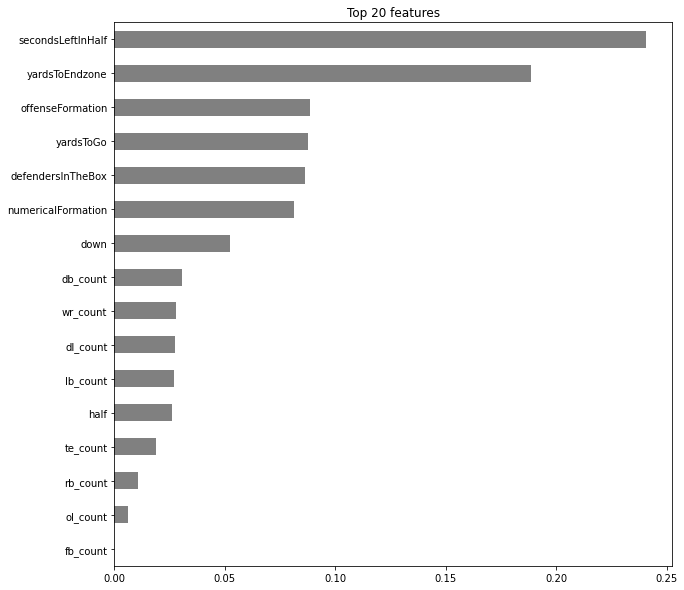

In [51]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [52]:
boost = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(random_state=42, n_estimators=100, n_jobs=-1)
);

boost.fit(X_train, y_train);
y_pred = pipeline.predict(X_val)

In [53]:
print('Train Accuracy', boost.score(X_train, y_train))
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print('Test Accuracy', boost.score(X_test, y_test))

Train Accuracy 0.7614957049014653
Validation Accuracy 0.7351900972590628
Test Accuracy 0.7550839964633068


gradient boosting Score R^2 Score 0.7559681697612732


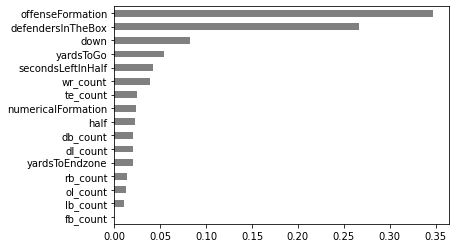

In [54]:
# R2 score
boost_score = boost.score(X_val, y_val,)
print(f'gradient boosting Score R^2 Score {boost_score}');

# plotting the feature importances
model = boost.named_steps['xgbclassifier']
encoder = boost.named_steps['ordinalencoder']
columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, columns)
importances.sort_values().plot.barh(color='grey');

In [55]:
from joblib import dump
dump(boost, 'xgb.joblib', compress = True)

['xgb.joblib']

In [56]:
from google.colab import files
files.download('xgb.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# What if we tried all the features?
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegression(n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.7528735632183908


In [58]:
from joblib import dump
dump(model, 'log.joblib', compress = True)
files.download('log.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
def predict(half, secondsLeftInHalf, down, yardsToGo, yardsToEndzone, defendersInTheBox, rb_count, te_count, wr_count, ol_count, fb_count, dl_count, db_count, lb_count, offenseFormation, numericalFormation):
    df = pd.DataFrame(
        columns=['half', 'secondsLeftInHalf', 'down', 'yardsToGo', 'yardsToEndzone', 'defendersInTheBox', 'rb_count', 'te_count', 'wr_count', 'ol_count', 'fb_count', 'dl_count', 'db_count', 'lb_count', 'offenseFormation', 'numericalFormation'],
        data=[[half, secondsLeftInHalf, down, yardsToGo, yardsToEndzone, defendersInTheBox, rb_count, te_count, wr_count, ol_count, fb_count, dl_count, db_count, lb_count, offenseFormation, numericalFormation]]
    )
    yp = pipeline.predict(df)[0]
    return yp

In [60]:
predict(1, 1800, 1, 10, 75, 8, 2, 1, 2, 0, 0, 3, 4, 4, 'I_FORM', 2)

'Passing'

In [61]:
df.head(100)

,half,secondsLeftInHalf,down,yardsToGo,yardsToEndzone,defendersInTheBox,rb_count,te_count,wr_count,ol_count,fb_count,dl_count,db_count,lb_count,offenseFormation,numericalFormation,PlayType
9317,1,1796,1,10,74.0,7.0,1,2,2,0,0,4,4,3,I_FORM,2,Rushing
13683,1,1800,1,10,75.0,8.0,1,1,3,0,0,4,4,3,SINGLEBACK,1,Rushing
1685,1,1800,1,10,75.0,7.0,2,1,2,0,0,3,4,4,I_FORM,2,Rushing
9747,1,1800,1,10,75.0,7.0,1,2,2,0,0,4,4,3,I_FORM,2,Rushing
4878,1,1800,1,10,75.0,6.0,1,1,3,0,0,3,4,4,SHOTGUN,0,Passing
2410,1,1800,1,10,75.0,5.0,1,3,1,0,0,4,4,3,EMPTY,3,Passing
2742,1,1800,1,10,75.0,6.0,1,1,3,0,0,4,5,2,SHOTGUN,0,Rushing
1537,1,1800,1,10,75.0,7.0,1,2,2,0,0,3,4,4,SINGLEBACK,1,Rushing
11480,1,1800,1,10,75.0,7.0,1,1,3,0,0,2,4,5,SINGLEBACK,1,Rushing
5183,1,1800,1,10,75.0,8.0,2,1,2,0,0,3,4,4,I_FORM,2,Passing


In [63]:
pd.set_option("display.max_columns", None)
import eli5
from eli5.sklearn import PermutationImportance

preprocessor = ce.OrdinalEncoder()
X_train_transformed = preprocessor.fit_transform(X_train[features])

model = XGBClassifier(random_state=42, n_estimators=100, n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=5, cv='prefit')
permuter.fit(X_train_transformed, y_train)
eli5.show_weights(permuter, top=None, feature_names=features)

Weight,Feature
0.1523 ± 0.0102,offenseFormation
0.0384 ± 0.0047,down
0.0234 ± 0.0038,yardsToGo
0.0198 ± 0.0013,secondsLeftInHalf
0.0125 ± 0.0020,defendersInTheBox
0.0101 ± 0.0015,yardsToEndzone
0.0069 ± 0.0010,wr_count
0.0011 ± 0.0005,half
0.0008 ± 0.0004,dl_count
0.0007 ± 0.0003,ol_count


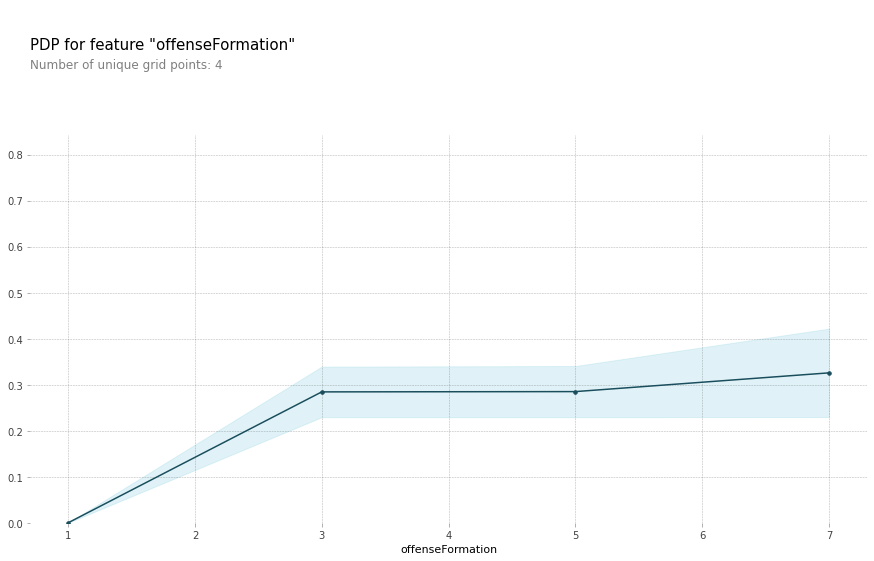

In [67]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='offenseFormation'



pdp_isolated = pdp_isolate(model=model, dataset=X_train_transformed, 
                           model_features=X_train_transformed.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

In [68]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted Passing', 'Predicted Rushing'],
 ['Actual Passing', 'Actual Rushing'])

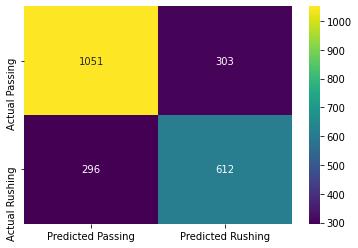

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

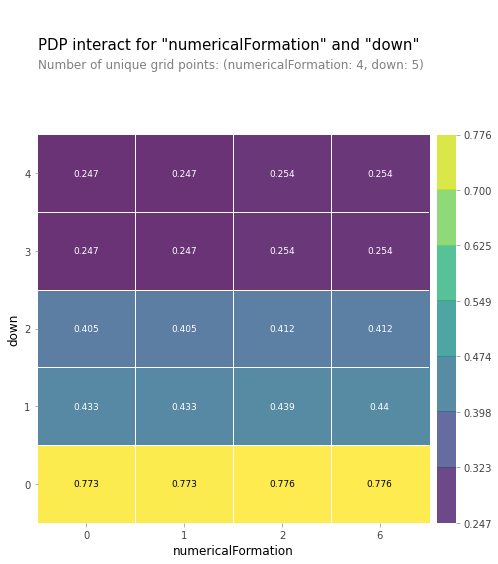

In [71]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['numericalFormation', 'down']

interaction = pdp_interact(
    model=model, 
    dataset=X_train_transformed, 
    model_features=X_train_transformed.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);